# Try-this Exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

Let's return to our spectrum "test_spectrum.dat" again.  As noted in lecture08_Bayesian_Inference, the spectrum was synthesized using a power law and a Lorentzian profile, as below.

Use MCMC to model the posterior probability distribution for spectrum, as was done in lecture08_Bayesian_Inference.ipynb, but this time let all the parameters vary.   These will be:
 - gamma (Lorentzian profile gamma)
 - offset (Lorentzian central wavelength)
 - lor_norm (Lorentzian normalization
 - slope (Power-law slope)
 - pl_norm (power-law normalization at 6000.0 Angstroms)
 
As modeled in the example above:
 - set up the likelihood, the prior, and the log probability.
 - set up the starting points for the walkers.
 - run the emcee
 - analyze the results.  In particular, produce histograms of the best fitting values.
 - compare the MCMC results for the line profile (normalization, width and location) with those you got from fitting the data with the Lorentzian profile in Problem 3 of lecture07_Model_Fitting.

### Answer:

I pretty much did the exact method as in the lecture, and my results are below.

In [2]:
# observed data {x_i}
fn = '../tt7/test_spectrum.dat'
data = np.loadtxt(fn)
wave = data[:, 0]
flux = data[:, 1]
eflux = data[:, 2]

# expected/guess parameters
gamma = 8.
offset = 6000.
lor_norm = 200.
slope = -1.
pl_norm = 5.

p0 = np.array([gamma, offset, lor_norm, slope, pl_norm])

param_constraints = {
    'gamma': (7, 9),
    'offset': (5500, 6500),
    'lor_norm': (190, 210),
    'slope': (-0.5, -1.5),
    'pl_norm': (3, 7),
}

In [3]:
# our spectral model
def lor_profile(wave, gamma, offset):
    f1 = gamma / np.pi
    f2 = (wave - offset)**2 + gamma**2
    return f1 / f2

def power_law(wave, scale, power):
    return (scale * wave)**power

def spectral_model(params, wave):
    gamma, offset, lor_norm, slope, pl_norm = params

    scale = 1. / 6000.
    bg = pl_norm * power_law(wave, scale, slope)
    feat = lor_norm * lor_profile(wave, gamma, offset)
    
    return bg + feat

# define the (log) posterior
def log_like(params, X, y, yerr):
    model = spectral_model(params, X)
    sum_terms = ((y - model) / yerr)**2
    return -0.5 * np.sum(sum_terms)

def log_prior(params):
    within_constraint = [
        abs(_min) <= abs(param) <= abs(_max) 
        for (_min, _max), param in zip(param_constraints.values(), params)
    ]

    if np.all(within_constraint):
        return 0.

    return -np.inf

def log_post(params, X, y, yerr):
    _log_prior = log_prior(params)
    if not np.isfinite(_log_prior):
        return _log_prior

    return _log_prior + log_like(params, X, y, yerr)

In [4]:
# setup initial walkers
n_walkers = 100
n_dim = len(p0)
init_params = p0.T + 0.1 * np.random.randn(n_walkers, n_dim)

# run simulations
n_sims = 500

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, args=(wave, flux, eflux))
sampler.run_mcmc(init_params, n_sims)

chain = sampler.chain
lnprob = sampler.lnprobability
acceptance = sampler.acceptance_fraction

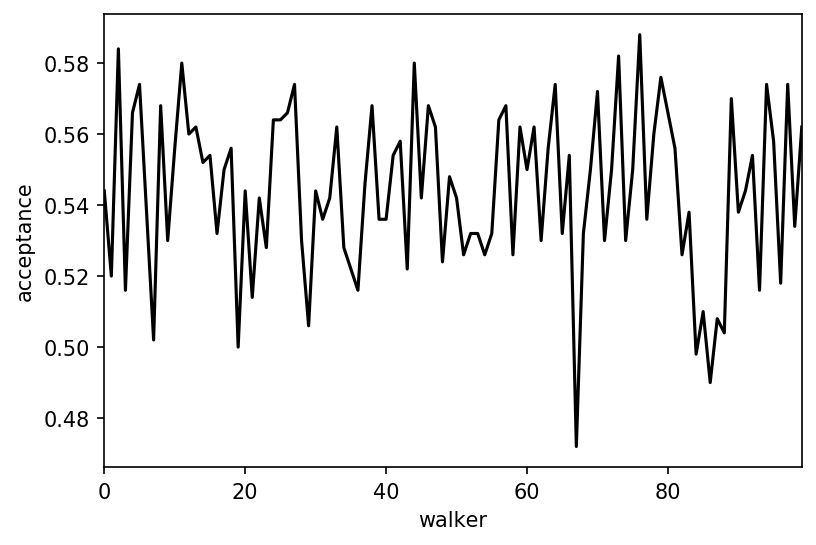

In [5]:
fig, ax = plt.subplots(dpi=150)

ax.plot(acceptance, c='k')

ax.set_xlim(0, n_walkers - 1)
ax.set_xlabel('walker')
ax.set_ylabel('acceptance')

plt.show()

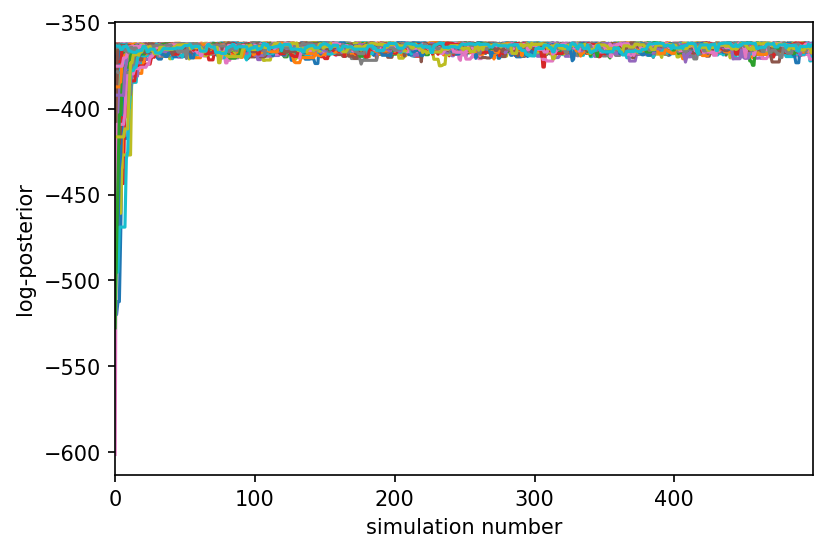

In [6]:
fig, ax = plt.subplots(dpi=150)

for simulation in lnprob:
    ax.plot(simulation)

ax.set_xlim(0, n_sims - 1)
ax.set_xlabel('simulation number')
ax.set_ylabel('log-posterior')

plt.show()

In [7]:
# get rid of burn-in, and setup for visualization
burnin = int(n_sims / 2)

lnprob = lnprob[:, burnin:].ravel()
sample_shape = ((n_sims - burnin) * n_walkers, n_dim)
sample = chain[:, burnin:, :].reshape(sample_shape)

gamma: 7.996 + 0.164 - 0.168
offset: 6000.070 + 0.121 - 0.121
lor_norm: 203.191 + 2.979 - 3.030
slope: -0.957 + 0.116 - 0.109
pl_norm: 4.962 + 0.013 - 0.013


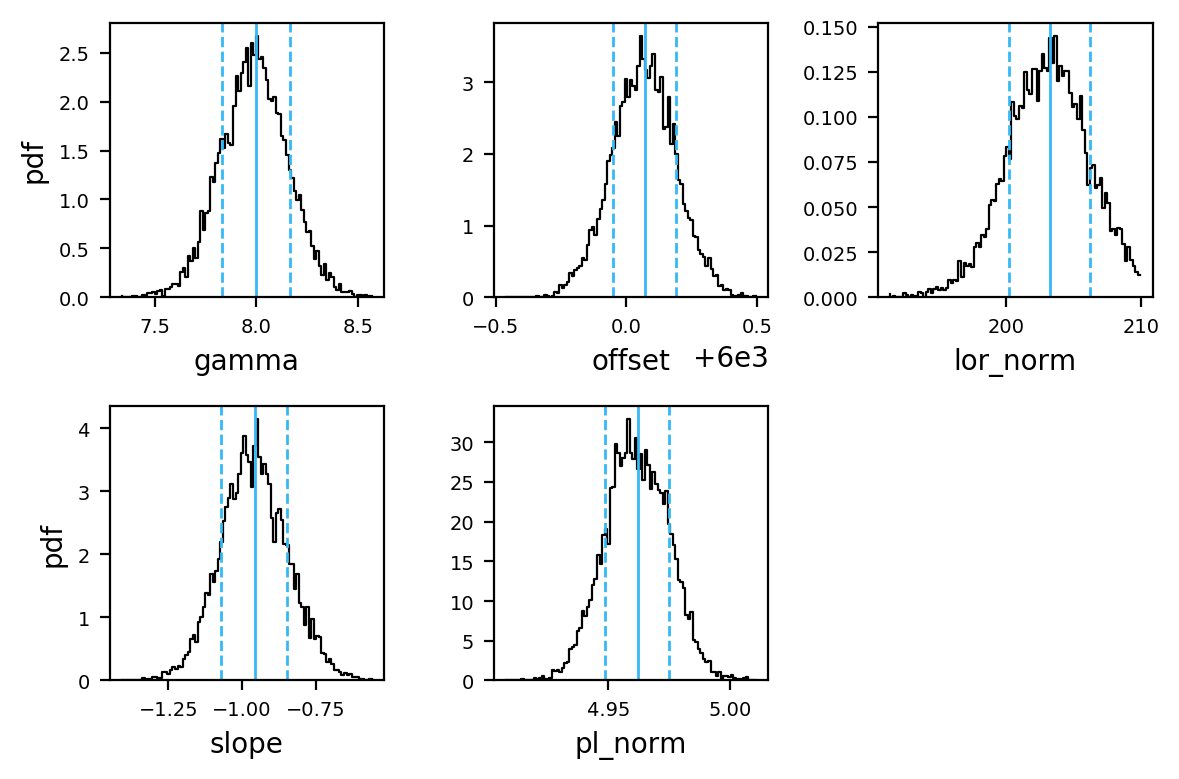

In [8]:
# plot
def gen_hist(sample, ind, n_bins=100):
    comp_hist_y, bin_edges = np.histogram(sample, bins=n_bins, density=True)
    binsize = bin_edges[1] - bin_edges[0]
    comp_hist_x = sample.min() + 0.5 * binsize + binsize * np.arange(n_bins)
    
    return comp_hist_x, comp_hist_y

pct_regions = (1. - 0.998650, 1. - 0.977250, 1. - 0.841345, 0.5, 0.841345, 0.977250, 0.998650)
n_samples = len(sample)

def conf_info(sample):
    param_conf_vals = np.zeros(len(pct_regions))
    x2 = np.sort(sample)
    f2 = np.arange(n_samples) / n_samples
    param_conf_vals = np.interp(pct_regions, f2, x2)
    
    med = param_conf_vals[3]
    sig_up = param_conf_vals[4] - param_conf_vals[3]
    sig_down = param_conf_vals[3] - param_conf_vals[2]
    
    return abs(sig_down), med, abs(sig_up)

n_rows = 2
n_cols = 3
fig, ax = plt.subplots(n_rows, n_cols, dpi=200)

for i, param in enumerate(param_constraints):
    plot_ind = (int(i / n_cols), i % n_cols)
    _ax = ax[plot_ind]

    x, y = gen_hist(sample[:, i], i)
    sig_down, med, sig_up = conf_info(sample[:, i])
    
    _ax.plot(x, y, drawstyle='steps', c='k', lw=0.8)
    _ax.axvline(med, ls='-', c='#34b9f7', lw=1)
    _ax.axvline(med + sig_down, ls='--', c='#34b9f7', lw=1)
    _ax.axvline(med - sig_up, ls='--', c='#34b9f7', lw=1)
    
    print(f'{param}: {med:.3f} + {sig_up:.3f} - {sig_down:.3f}')
    
    _ax.set_xlabel(param)
    if not i % n_cols:
        _ax.set_ylabel('pdf')
    _ax.set_ylim(bottom=0.)
    _ax.tick_params(axis='both', which='major', labelsize=7)

ax[1, 2].set_xticks([])    
ax[1, 2].set_yticks([])    
[ax[1, 2].spines[x].set_visible(False) for x in ax[1, 2].spines]

plt.tight_layout()
plt.show()

In [9]:
# convert fwhm to angstroms
c = 2.998e5
fwhm_kms = 796.268
pos = 6000.09
epos = 0.123751

fwhm_ang = fwhm_kms * pos / c
efwhm_ang = fwhm_ang * epos / pos
gamma_sherpa = fwhm_ang / 2
print(f'{gamma_sherpa:.3f} +- {efwhm_ang:.3f}')

7.968 +- 0.000


From Sherpa, I got that the FWHM is $796.268 \pm 0.000\ \text{km s}^{-1}$ (in angstroms, the corresponding $\gamma$ is $7.968 \pm 0.000\ \AA$ as calculated above), the position/offset is $6000.090 \pm 0.124\ \AA$, and the Lorentzian amplitude is $202.822 \pm 2.427\ \text{[flux density]}$. From MCMC, I just found $\gamma$ to be $7.989^{+0.164}_{-0.175}\ \AA$, the offset is $6000.073^{+0.125}_{-0.126}\ \AA$, and the Lorentzian amplitude is $203.084^{+3.010}_{-3.111}\ \text{[flux density]}$. These values are all quite similar in median/mean, however the MCMC method tends to give larger uncertainty with my number of simulations/walkers (except for the offset).